In [1]:
# 기본 모듈 로드 (numpy, pandas)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# sklearn 모듈 로드
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.metrics import mean_squared_error
# torch 임포트
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import math # Positional Encoding에 사용

# 시드 설정 (재현성 확보)
torch.manual_seed(0)
np.random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
import os

/home/shinds/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Using device: cuda


In [2]:
os.getcwd()

'/home/shinds/my_document/advrobot/3_forecasting'

In [3]:
print("### 데이터 로딩 및 전처리 ###")
# 기초데이터 불러오기
# 파일 경로는 실제 파일 위치에 맞게 수정해주세요.
try:
    X = pd.read_csv('../BASEL_X.csv')
    Y = pd.read_csv('../BASEL_Y.csv') # Y는 예측 문제에서는 사용하지 않음
except FileNotFoundError:
    print("CSV 파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")
    exit()

# 데이터 시간 순 정렬 (시계열 처리에 필수)
X['DATE'] = pd.to_datetime(X['DATE'])
X = X.sort_values(by='DATE').reset_index(drop=True)

# feature 만들기

# 1. temp_range (하루 온도 변화량)
X['temp_range'] = X['BASEL_temp_max'] - X['BASEL_temp_min']

# 아래의 컬럼들은 효과 없음!
# # 2. humidity_pressure_ratio (습도 대비 기압 비율)
# epsilon = 1e-6
# X['humidity_pressure_ratio'] = X['BASEL_humidity'] / (X['BASEL_pressure'] + epsilon)

# # 3. cloud_sun_ratio (구름량 대비 햇빛량 비율)
# X['cloud_sun_ratio'] = X['BASEL_cloud_cover'] / (X['BASEL_sunshine'] + epsilon)

# # 4. radiation_precip_ratio (방사선량 대비 강수량 비율)
# X['radiation_precip_ratio'] = X['BASEL_global_radiation'] / (X['BASEL_precipitation'] + epsilon)



print("### 예측 문제 셋팅 ###")


#feature_columns = [
    #'BASEL_cloud_cover', 'BASEL_humidity', 'BASEL_pressure',
    #'BASEL_global_radiation', 'BASEL_precipitation', 'BASEL_sunshine', 'BASEL_temp_mean',
    #'temp_range' ]
# 중요한 컬럼들만 사용!
feature_columns = [
    'BASEL_global_radiation', 'BASEL_precipitation',  'BASEL_temp_mean', 'BASEL_temp_max','BASEL_temp_min',
    'temp_range' ]
target_column = 'BASEL_temp_mean' # 예측할 컬럼 이름
input_dim = len(feature_columns) # 입력 특징 차원
output_dim = 1 # 예측할 출력 특징 차원 (temp_mean 하나)

X_pre = X[feature_columns]

# 스케일링 (시계열 데이터 전체에 대해 수행)
# Robust 사용!
# scaler = MinMaxScaler()
# scaler = StandardScaler()
scaler = RobustScaler()

X_scaled = scaler.fit_transform(X_pre)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_columns) # 스케일링된 데이터로 DataFrame 재생성
#X_scaled_df = X_pre.copy()

print(f"스케일링 완료된 데이터 Shape: {X_scaled_df.shape}")

### 데이터 로딩 및 전처리 ###
### 예측 문제 셋팅 ###
스케일링 완료된 데이터 Shape: (3654, 6)


In [4]:
print("\n### 시퀀스 데이터 생성 ###")
# 시계열 시퀀스 (window) 생성
# 이전 window_in 길이로 다음 window_out 길이 예측

window_in = 4# 입력 시퀀스 길이 (이전 4일)
window_out = 3 # 예측 시퀀스 길이 (다음 3일)
stride = 1 # 시퀀스 생성 시 이동 간격 (데이터 양을 늘리기 위해 1로 설정)

X_ts, Y_ts = [], []
# 슬라이딩 윈도우 적용
# 시퀀스 생성 범위: [start]부터 [start + window_in + window_out - 1]까지
# 예측 대상의 마지막 시점 인덱스는 start + window_in + window_out - 1
for start in range(0, len(X_scaled_df) - window_in - window_out + 1, stride):
    end_input = start + window_in # 입력 시퀀스 끝 인덱스 (포함 안됨)
    end_output = end_input + window_out # 출력 시퀀스 끝 인덱스 (포함 안됨)

    # 입력 시퀀스: start 부터 end_input-1 까지의 모든 특징
    x_seq = X_scaled_df.iloc[start : end_input, :].values
    # 출력 시퀀스: end_input 부터 end_output-1 까지의 'temp_mean' 값
    # Y_ts는 (num_sequences, window_out) 형태가 되도록 함
    y_seq = X_scaled_df.iloc[end_input : end_output, X_scaled_df.columns.get_loc(target_column)].values

    X_ts.append(x_seq)
    Y_ts.append(y_seq)

X_ts_np = np.array(X_ts)
Y_ts_np = np.array(Y_ts) # Shape: (num_sequences, window_out)

print(f"생성된 입력 시퀀스 Shape: {X_ts_np.shape} (num_sequences, window_in, input_dim)")
print(f"생성된 출력 시퀀스 Shape: {Y_ts_np.shape} (num_sequences, window_out)")


### 시퀀스 데이터 생성 ###
생성된 입력 시퀀스 Shape: (3648, 4, 6) (num_sequences, window_in, input_dim)
생성된 출력 시퀀스 Shape: (3648, 3) (num_sequences, window_out)


In [5]:
print("\n### Train, Validation, Test set 분할 (시간 순서 기준, 고정 Test Set) ###")

total_sequences = X_ts_np.shape[0]
test_size = 400  # 테스트셋은 마지막 400개 고정
remaining_size = total_sequences - test_size

# 나머지 데이터를 train/val로 비율 나누기
train_ratio = 0.6  # train/validation 분할 비율 (남은 데이터 기준)

train_size = int(remaining_size * train_ratio)
val_size = remaining_size - train_size

# 데이터 분할
X_train = X_ts_np[:train_size]
Y_train = Y_ts_np[:train_size]

X_val = X_ts_np[train_size : train_size + val_size]
Y_val = Y_ts_np[train_size : train_size + val_size]

X_test = X_ts_np[remaining_size:]  # 마지막 400개
Y_test = Y_ts_np[remaining_size:]

print(f"Train set Shape: {X_train.shape}, {Y_train.shape}")
print(f"Validation set Shape: {X_val.shape}, {Y_val.shape}")
print(f"Test set Shape: {X_test.shape}, {Y_test.shape}")



### Train, Validation, Test set 분할 (시간 순서 기준, 고정 Test Set) ###
Train set Shape: (1948, 4, 6), (1948, 3)
Validation set Shape: (1300, 4, 6), (1300, 3)
Test set Shape: (400, 4, 6), (400, 3)


In [6]:
print("\n### PyTorch DataLoader 준비 ###")
# TensorDataset 및 DataLoader 생성
# Y_train/Y_val/Y_test는 예측할 대상 시퀀스 (shape: ..., window_out)
D_train = TensorDataset(torch.Tensor(X_train).to(device), torch.Tensor(Y_train).to(device))
D_val = TensorDataset(torch.Tensor(X_val).to(device), torch.Tensor(Y_val).to(device))
D_test = TensorDataset(torch.Tensor(X_test).to(device), torch.Tensor(Y_test).to(device))

# 트랜스포머는 메모리를 더 사용할 수 있으므로 배치 사이즈를 조정
batch_size = 128
Train_Loader = DataLoader(D_train, batch_size=batch_size, shuffle=True, drop_last=False) # 학습 시 셔플
Val_Loader = DataLoader(D_val, batch_size=batch_size, shuffle=False, drop_last=False) # 검증 시 셔플 안 함
Test_Loader = DataLoader(D_test, batch_size=batch_size, shuffle=False, drop_last=False) # 테스트 시 셔플 안 함

print(f"Train_Loader 배치 개수: {len(Train_Loader)}")
print(f"Val_Loader 배치 개수: {len(Val_Loader)}")
print(f"Test_Loader 배치 개수: {len(Test_Loader)}")


### PyTorch DataLoader 준비 ###


Train_Loader 배치 개수: 16
Val_Loader 배치 개수: 11
Test_Loader 배치 개수: 4


In [7]:
print("\n### Transformer 모델 정의 및 학습 ###")

# Positional Encoding 모듈 (시퀀스 순서 정보 추가)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1) # Shape: (max_len, 1, d_model)
        self.register_buffer('pe', pe) # pe is not a trainable parameter

    def forward(self, x):
        # x shape: (seq_len, batch_size, d_model)
        # self.pe shape: (max_len, 1, d_model)
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


# Transformer Encoder-Decoder 모델
class TransformerPredictor(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, dropout=0.1):
        super().__init__()
        self.model_type = 'Transformer'
        self.d_model = d_model
        self.output_dim = output_dim # 예측할 출력 차원 (여기서는 1)

        # 입력 특징 차원 -> d_model 차원으로 매핑하는 레이어
        self.encoder_input_layer = nn.Linear(input_dim, d_model)
        # 디코더 입력 특징 차원 (예측 대상의 차원) -> d_model 차원으로 매핑하는 레이어
        self.decoder_input_layer = nn.Linear(output_dim, d_model)
        # 트랜스포머 디코더 출력 (d_model) -> 최종 출력 차원 (output_dim)으로 매핑하는 레이어
        self.output_layer = nn.Linear(d_model, output_dim)

        # Positional Encoding 레이어
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.pos_decoder = PositionalEncoding(d_model, dropout) # 디코더도 Positional Encoding 필요

        # 트랜스포머 핵심 레이어
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)

        decoder_layers = nn.TransformerDecoderLayer(d_model, nhead, dropout=dropout)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layers, num_decoder_layers)

        # Initialization (optional, but can help)
        self.init_weights()

    def init_weights(self):
        # 가중치 초기화 (예시)
        initrange = 0.1
        self.encoder_input_layer.weight.data.uniform_(-initrange, initrange)
        self.decoder_input_layer.weight.data.uniform_(-initrange, initrange)
        self.output_layer.bias.data.zero_()
        self.output_layer.weight.data.uniform_(-initrange, initrange)


    def forward(self, src, tgt, src_mask, tgt_mask):
        # src shape: (batch_size, seq_in, input_dim) - Encoder 입력
        # tgt shape: (batch_size, seq_out, output_dim) - Decoder 입력 (학습 시 Teacher Forcing)

        # 트랜스포머 레이어는 (seq_len, batch_size, feature_dim) 형태 입력을 선호하므로 차원 변경
        src = src.permute(1, 0, 2) # -> (seq_in, batch_size, input_dim)
        tgt = tgt.permute(1, 0, 2) # -> (seq_out, batch_size, output_dim)

        # 입력/출력 선형 레이어 및 Positional Encoding 적용
        src = self.encoder_input_layer(src) # -> (seq_in, batch_size, d_model)
        src = self.pos_encoder(src)        # + Positional Encoding

        tgt = self.decoder_input_layer(tgt) # -> (seq_out, batch_size, d_model)
        tgt = self.pos_decoder(tgt)        # + Positional Encoding


        # 트랜스포머 순전파
        memory = self.transformer_encoder(src, src_mask) # memory shape: (seq_in, batch_size, d_model)
        # 디코더 입력: tgt, 메모리: memory (인코더 출력), 타겟 마스크: tgt_mask (인과적 마스크), 메모리 마스크: None
        output = self.transformer_decoder(tgt, memory, tgt_mask, None) # output shape: (seq_out, batch_size, d_model)

        # 최종 출력 레이어 적용
        output = self.output_layer(output) # -> (seq_out, batch_size, output_dim)

        # 원래 배치 형태로 차원 변경 (batch_size, seq_len, feature_dim)
        output = output.permute(1, 0, 2) # -> (batch_size, seq_out, output_dim)

        return output # 최종 예측 시퀀스

# Helper function to generate causal mask (look-ahead mask)
# 디코더가 미래 시점의 정보를 보지 못하도록 마스크 생성
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    # 마스크 형태: (sz, sz)
    return mask.to(device)


# Helper function to shift the target sequence for decoder input (Teacher Forcing용)
# 타겟 시퀀스를 오른쪽으로 한 스텝 쉬프트하고 시작 토큰(여기서는 0 벡터)을 앞에 붙임
def shift_sequence(sequence, start_token_value=0.0):
    # sequence shape: (batch_size, seq_len, feature_dim)
    batch_size, seq_len, feature_dim = sequence.size()
    # 시작 토큰: (batch_size, 1, feature_dim)
    start_token = torch.full((batch_size, 1, feature_dim), start_token_value, device=sequence.device)
    # 실제 시퀀스는 마지막 요소 제외
    shifted_sequence = sequence[:, :-1, :]
    # 시작 토큰과 실제 시퀀스 연결
    shifted_sequence = torch.cat([start_token, shifted_sequence], dim=1)
    # 최종 shape: (batch_size, seq_len, feature_dim)
    return shifted_sequence


### Transformer 모델 정의 및 학습 ###


In [8]:
# 모델 파라미터 (하이퍼파라미터)
d_model = 64
nhead = 8
num_encoder_layers = 2
num_decoder_layers = 2
dropout = 0.1

transformer_model = TransformerPredictor(
    input_dim,
    output_dim,
    d_model,
    nhead,
    num_encoder_layers,
    num_decoder_layers,
    dropout
).to(device)

# 손실 함수 및 옵티마이저
criterion = nn.MSELoss()
optimizer = optim.Adam(transformer_model.parameters(), lr=1e-4)

# 학습 파라미터
num_epochs = 300
best_val_loss = float('inf')
patience = 30
epochs_no_improve = 0
noise_std = 0.01

# Adaptive Scheduled Sampling 설정
initial_teacher_forcing_ratio = 1.0
final_teacher_forcing_ratio = 0.1
decay_epochs = 100  # 몇 epoch 동안 teacher forcing ratio를 선형 감소할지
teacher_forcing_ratio = initial_teacher_forcing_ratio
print(f"Adaptive Scheduled Sampling 학습 시작 ({num_epochs} 에폭)...")

for epoch in range(num_epochs):
    transformer_model.train()
    total_train_loss = 0

    for batch_x, batch_y in Train_Loader:
        batch_y = batch_y.unsqueeze(-1)

        # Noise Injection
        batch_x_noisy = batch_x + torch.randn_like(batch_x) * noise_std
        optimizer.zero_grad()

        batch_size = batch_x_noisy.size(0)
        decoder_input_sequence = torch.full((batch_size, 1, output_dim), 0.0, device=device)

        src_mask = None
        memory = transformer_model.transformer_encoder(
            transformer_model.pos_encoder(transformer_model.encoder_input_layer(batch_x_noisy.permute(1, 0, 2))),
            src_mask
        )

        outputs = []
        for t in range(window_out):
            tgt = transformer_model.pos_decoder(
                transformer_model.decoder_input_layer(decoder_input_sequence.permute(1, 0, 2))
            )
            tgt_mask = generate_square_subsequent_mask(decoder_input_sequence.size(1))

            output = transformer_model.transformer_decoder(tgt, memory, tgt_mask)
            prediction = transformer_model.output_layer(output[-1, :, :])
            outputs.append(prediction.unsqueeze(1))

            # Adaptive Scheduled Sampling 적용
            use_teacher_forcing = np.random.rand() < teacher_forcing_ratio
            if use_teacher_forcing:
                next_input = batch_y[:, t, :].unsqueeze(1)
            else:
                next_input = prediction.unsqueeze(1)

            decoder_input_sequence = torch.cat([decoder_input_sequence, next_input], dim=1)

        outputs = torch.cat(outputs, dim=1)

        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * batch_x.size(0)

    avg_train_loss = total_train_loss / len(Train_Loader.dataset)

    # Validation
    transformer_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch_x_val, batch_y_val in Val_Loader:
            batch_y_val = batch_y_val.unsqueeze(-1)

            decoder_input_sequence_val = shift_sequence(batch_y_val, start_token_value=0.0)
            prediction_seq_val = transformer_model(batch_x_val, decoder_input_sequence_val, None, generate_square_subsequent_mask(window_out))
            val_loss = criterion(prediction_seq_val, batch_y_val)

            total_val_loss += val_loss.item() * batch_x_val.size(0)

    avg_val_loss = total_val_loss / len(Val_Loader.dataset)

    # --- Teacher Forcing Ratio 선형 감소 ---
    teacher_forcing_ratio = max(
        final_teacher_forcing_ratio,
        initial_teacher_forcing_ratio - (epoch / decay_epochs) * (initial_teacher_forcing_ratio - final_teacher_forcing_ratio)
    )

    # 출력
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {avg_train_loss:.6f}, Val Loss = {avg_val_loss:.6f}, Teacher Forcing Ratio = {teacher_forcing_ratio:.3f}")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"조기 종료! 검증 손실이 {patience} 에폭 동안 개선되지 않았습니다.")
            break

print("Transformer 모델 Adaptive Scheduled Sampling 학습 완료.")


/home/shinds/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Adaptive Scheduled Sampling 학습 시작 (300 에폭)...
Epoch 1/300: Train Loss = 0.369189, Val Loss = 0.245833, Teacher Forcing Ratio = 1.000
Epoch 2/300: Train Loss = 0.199577, Val Loss = 0.105990, Teacher Forcing Ratio = 0.991
Epoch 3/300: Train Loss = 0.118459, Val Loss = 0.077562, Teacher Forcing Ratio = 0.982
Epoch 4/300: Train Loss = 0.108245, Val Loss = 0.078023, Teacher Forcing Ratio = 0.973
Epoch 5/300: Train Loss = 0.099899, Val Loss = 0.076163, Teacher Forcing Ratio = 0.964
Epoch 6/300: Train Loss = 0.099419, Val Loss = 0.076175, Teacher Forcing Ratio = 0.955
Epoch 7/300: Train Loss = 0.096318, Val Loss = 0.073167, Teacher Forcing Ratio = 0.946
Epoch 8/300: Train Loss = 0.093230, Val Loss = 0.070835, Teacher Forcing Ratio = 0.937
Epoch 9/300: Train Loss = 0.092062, Val Loss = 0.073259, Teacher Forcing Ratio = 0.928
Epoch 10/300: Train Loss = 0.089720, Val Loss = 0.071140, Teacher Forcing Ratio = 0.919
Epoch 11/300: Train Loss = 0.087227, Val Loss = 0.066867, Teacher Forcing Ratio = 0

In [9]:
print("\n### 학습된 모델로 테스트셋 예측 및 평가 (Autoregressive Inference) ###")
# 트랜스포머 추론은 한 스텝씩 자동 회귀 방식으로 수행

transformer_model.eval() # 평가 모드
prediction_sequences = [] # 예측된 시퀀스들을 저장할 리스트
ground_truth_sequences = [] # 실제 시퀀스들을 저장할 리스트
test_losses = [] # 각 시퀀스별 MSE 저장

with torch.no_grad(): # 그래디언트 계산 비활성화
    for batch_x, batch_y in Test_Loader:
        # batch_x shape: (batch_size, window_in, input_dim)
        # batch_y shape: (batch_size, window_out)

        batch_size_actual = batch_x.size(0) # 배치의 실제 크기 (마지막 배치는 더 작을 수 있음)

        # 인코더 입력 준비 (테스트 배치 전체에 대해 수행)
        # src shape: (window_in, batch_size_actual, d_model)
        src = transformer_model.encoder_input_layer(batch_x.permute(1, 0, 2))
        src = transformer_model.pos_encoder(src)
        # 인코더 순전파
        # memory shape: (window_in, batch_size_actual, d_model)
        memory = transformer_model.transformer_encoder(src, None) # Encoder output (memory)


        # >>> 자동 회귀 디코딩 루프 <<<
        # 각 샘플별로 예측 시퀀스를 생성
        # Decoder input은 예측 스텝에 따라 달라지므로 루프 내에서 처리
        
        # 초기 디코더 입력: 시작 토큰 (각 샘플별로 필요)
        # initial_decoder_input shape: (batch_size_actual, 1, output_dim=1)
        # 시작 토큰 값은 학습 시 사용한 것과 동일
        initial_decoder_input = torch.full((batch_size_actual, 1, output_dim), 0.0, device=device)

        # 현재까지 예측된 시퀀스 (처음에는 시작 토큰만 있음)
        # current_predicted_sequence shape: (batch_size_actual, current_seq_len, output_dim=1)
        current_predicted_sequence = initial_decoder_input

        # window_out 스텝만큼 반복하여 예측
        for _ in range(window_out): # Predict window_out steps
             # 디코더 입력 준비: 현재까지 예측된 시퀀스를 사용
             # tgt shape: (current_seq_len, batch_size_actual, output_dim=1) -> map to d_model
             tgt = transformer_model.decoder_input_layer(current_predicted_sequence.permute(1, 0, 2))
             tgt = transformer_model.pos_decoder(tgt)

             # 인과적 마스크 생성: 현재 디코더 입력 시퀀스 길이에 맞게 생성
             # mask_sz = current_predicted_sequence.size(1)
             tgt_mask_inf = generate_square_subsequent_mask(current_predicted_sequence.size(1))

             # 트랜스포머 디코더 순전파
             # output shape: (current_seq_len, batch_size_actual, d_model)
             # 디코더는 tgt와 memory를 받음
             output = transformer_model.transformer_decoder(tgt, memory, tgt_mask_inf, None)

             # 다음 스텝 예측: 디코더 출력의 가장 마지막 시점 ([ -1 , : , : ]) 결과를 사용
             # last_output_step shape: (batch_size_actual, d_model)
             last_output_step = output[-1, :, :]

             # 최종 출력 레이어를 통해 다음 값 예측
             # next_prediction shape: (batch_size_actual, output_dim=1)
             next_prediction = transformer_model.output_layer(last_output_step)
             # NaN 방지 추가
             next_prediction = torch.nan_to_num(next_prediction, nan=0.0)

             current_predicted_sequence = torch.cat([current_predicted_sequence, next_prediction.unsqueeze(1)], dim=1)

             # 예측된 다음 스텝을 현재까지의 예측 시퀀스에 추가
             # next_prediction shape (batch_size_actual, 1, output_dim=1) 로 차원 변경 후 연결
             

        # 최종 예측 시퀀스: 시작 토큰 제외 (첫 스텝 제외)
        # final_predicted_sequence shape: (batch_size_actual, window_out, output_dim=1)
        final_predicted_sequence = current_predicted_sequence[:, 1:, :] # 시작 토큰 (인덱스 0) 제외


        # 실제 타겟 시퀀스 준비 (평가를 위해)
        # batch_y shape: (batch_size_actual, window_out) -> (batch_size_actual, window_out, 1)
        actual_target_sequence = batch_y.unsqueeze(-1)


        # 예측된 시퀀스와 실제 시퀀스 저장
        prediction_sequences.append(final_predicted_sequence.cpu().numpy())
        ground_truth_sequences.append(actual_target_sequence.cpu().numpy())

        # 각 시퀀스별 MSE 계산
        # output shape: (batch_size_actual, window_out, 1), target shape: (batch_size_actual, window_out, 1)
        # MSE 계산은 MSELoss를 사용하거나 수동으로 (pred - target)**2 의 평균을 구함
        batch_mse = torch.mean((final_predicted_sequence - actual_target_sequence)**2, dim=[1, 2]) # 시퀀스 길이와 특징 차원에 대해 평균
        test_losses.append(batch_mse.cpu().numpy())


# 배치별 결과를 하나로 합침
prediction_sequences = np.concatenate(prediction_sequences) # shape: (num_test_sequences, window_out, 1)
ground_truth_sequences = np.concatenate(ground_truth_sequences) # shape: (num_test_sequences, window_out, 1)
test_losses = np.concatenate(test_losses) # shape: (num_test_sequences,) - 각 시퀀스별 평균 MSE





### 학습된 모델로 테스트셋 예측 및 평가 (Autoregressive Inference) ###


In [10]:
# Flatten
prediction_flat = prediction_sequences.squeeze(-1).reshape(-1, 1)
ground_truth_flat = ground_truth_sequences.squeeze(-1).reshape(-1, 1)
# robustscaler를 fit한 이후
feature_idx = feature_columns.index('BASEL_temp_mean')
median = scaler.center_[feature_idx]  # feature 별 중앙값
iqr = scaler.scale_[feature_idx]      # feature 별 IQR

# 복원
prediction_inverse = prediction_flat * iqr + median
ground_truth_inverse = ground_truth_flat * iqr + median


restored_mse = np.mean((prediction_inverse - ground_truth_inverse)**2)
overall_test_mse = np.mean(test_losses)
print(f"Transformer 테스트셋 평균 MSE (스케일된 값): {overall_test_mse:.6f}")
print(f"Transformer 테스트셋 평균 MSE (복원된 값): {restored_mse:.6f}")

Transformer 테스트셋 평균 MSE (스케일된 값): 0.058605
Transformer 테스트셋 평균 MSE (복원된 값): 7.885949


In [11]:
# 디버깅 용
print(prediction_sequences.shape)
print(ground_truth_sequences.shape)

print(np.isnan(prediction_sequences).any())
print(np.isnan(ground_truth_sequences).any())

(400, 3, 1)
(400, 3, 1)
False
False



### 예측 결과 시각화 ###


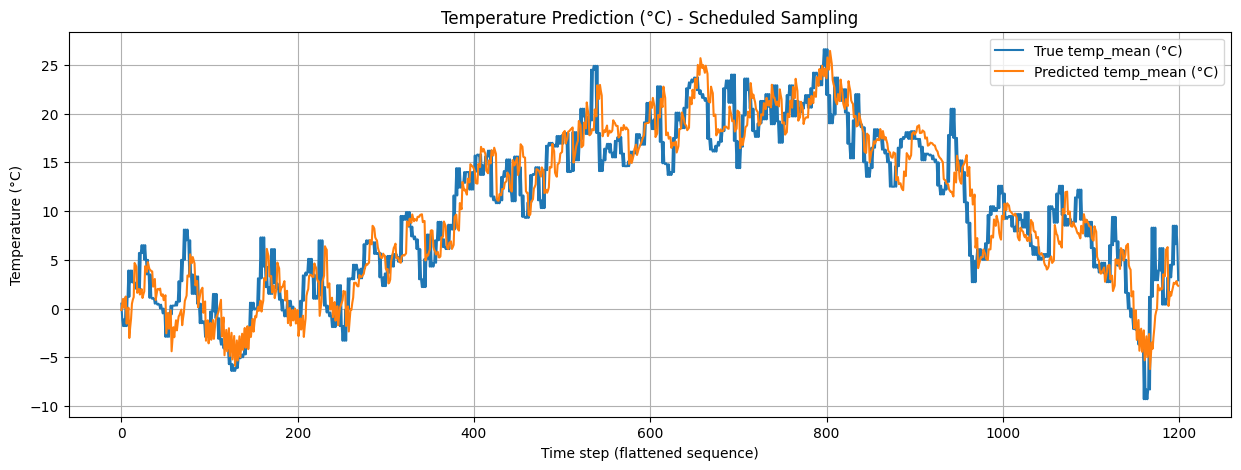


### 특정 시퀀스 예측 상세 시각화 (Inverse Transform 적용) ###


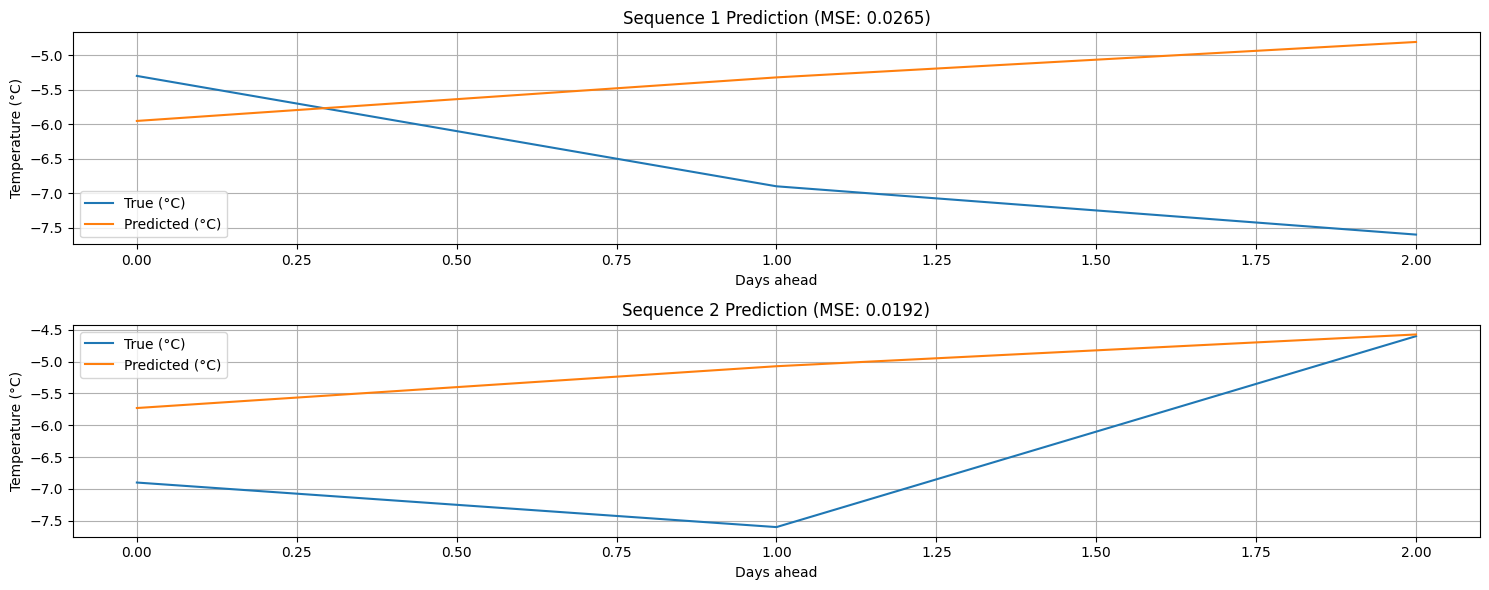

In [12]:
print("\n### 예측 결과 시각화 ###")
# temp_min, temp_max를 다시 설정
feature_idx = feature_columns.index('BASEL_temp_mean')
median = scaler.center_[feature_idx]
iqr = scaler.scale_[feature_idx]

temp_min = median - (iqr / 2)
temp_max = median + (iqr / 2)
# 전체 시퀀스를 평탄화하여 시각화
plt.figure(figsize=(15,5))
plt.plot(ground_truth_inverse, label="True temp_mean (°C)")
plt.plot(prediction_inverse, label="Predicted temp_mean (°C)")
plt.title("Temperature Prediction (°C) - Scheduled Sampling")
plt.xlabel("Time step (flattened sequence)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()

# 특정 시퀀스만 시각화하여 예측 결과 상세 확인
# 예시: 테스트셋의 첫 5개 시퀀스 확인

print("\n### 특정 시퀀스 예측 상세 시각화 (Inverse Transform 적용) ###")
num_sequences_to_plot = min(2, len(X_test))
plt.figure(figsize=(15, num_sequences_to_plot * 3))

for i in range(num_sequences_to_plot):
    plt.subplot(num_sequences_to_plot, 1, i + 1)
    time_steps = np.arange(window_out)
    
    # 스케일링 복원
    true_seq = ground_truth_sequences[i].squeeze(-1) * (temp_max - temp_min) + temp_min
    pred_seq = prediction_sequences[i].squeeze(-1) * (temp_max - temp_min) + temp_min

    plt.plot(time_steps, true_seq, label="True (°C)")
    plt.plot(time_steps, pred_seq, label="Predicted (°C)")
    plt.title(f"Sequence {i+1} Prediction (MSE: {test_losses[i]:.4f})")
    plt.xlabel("Days ahead")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()